# Portland Dungeon May 2017 #
This notebook documents work for the May 2017 Portland Dungeon Hackfest

### Goals
* Compare the vtune profiles of DESI spectral extraction code on
  Haswell vs. KNL to understand why per-core Haswell performance
  is 6-8x better than KNL (instead of ~2-3x)
* Identify KNL-specific hotspots
* Fix KNL-specific hotspots in order to achieve node parity between KNL and Haswell when parallelizing over multiple cores.

## Background

These benchmarks test the DESI spectral extraction code,
which is the most computationally intensive portion of our
data processing pipeline.  It performs a forward modeling analysis
of astronomical spectra projected onto 2D CCD images.

Each DESI "frame" has 500 spectra with ~4000 wavelengths each.
The extraction problem is subdivided into many sub-extractions
of $n$ spectra by $m$ wavelengths, where each sub-extraction involves
eigendecomposition of a $(n m \times nm)$ maxtrix.
The optimal choice of $n$ and $m$ balances a large number of small matrix algebra operations vs. a smaller number of larger calculations.

The plots below compare the per-core extraction rate (number of spectra x number of wavelengths extracted per second) vs. number of spectra per sub-extraction.  Higher is better.
Although Haswell and KNL have different optimal sub-extraction sizes, Haswell per-core consistently out-performs KNL by a factor of 6-8x.  We need to improve the per-core performance on KNL in order to achieve node parity with KNL vs. Haswell.


## Basic setup to run code ##

```
conda create -n portland python=3.5 astropy scipy numpy ipython
source activate portland
git clone https://github.com/desihub/specter
cd specter && python setup.py install && cd ..
git clone https://github.com/sbailey/knltest
cd knltest/code
python extract.py
```

## Performance Starting point: Cori Haswell vs KNL

Both IDP and Anaconda+MKL as tested on NERSC Cori 1/2 are shown, with nearly identical results for IDP vs. Anaconda+MKL.  The dominant difference is Haswell (Cori 1) vs. KNL (Cori 2).

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Raw data from runs on Cori Haswell and Cori KNL with
#- two different python distributions (IDP and ContinuumIO Anaconda+MKL)
nspec = np.array([5,10,15,20,25])
rate_hsw_idp = np.array([464.1, 623.0, 595.2, 303.6, 241.1])
rate_hsw_ana = np.array([466.3, 631.4, 599.6, 308.9, 244.1])
rate_knl_idp = np.array([ 54.2,  85.2,  98.1,  46.3,  39.0])
rate_knl_ana = np.array([ 53.9,  85.2,  97.8,  46.0,  39.0])

max(Haswell) / max(KNL) = 6.5


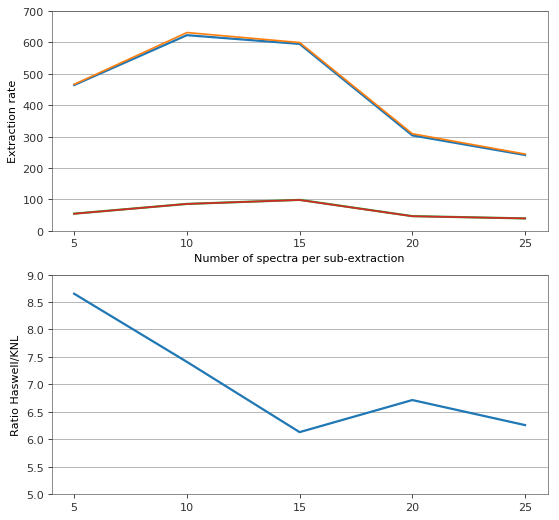

In [3]:
figure(figsize=(8,8))
subplot(211)
plot(nspec, rate_hsw_idp, lw=2, label='Haswell IDP')
plot(nspec, rate_hsw_ana, label='Haswell Anaconda')
plot(nspec, rate_knl_idp, lw=2, label='KNL IDP')
plot(nspec, rate_knl_ana, label='KNL Anaconda')
xticks(nspec)
xlabel('Number of spectra per sub-extraction')
ylabel('Extraction rate')
ylim(0,700)
grid(axis='y')

subplot(212)
plot(nspec, rate_hsw_ana / rate_knl_ana, lw=2)
xticks(nspec)
ylabel('Ratio Haswell/KNL')
ylim(5,9)
grid(axis='y')

best_ratio = max(rate_hsw_ana) / max(rate_knl_ana)
print('max(Haswell) / max(KNL) = {:.1f}'.format(best_ratio))

## Changes implemented
From most important to least important:
  * pre-compute PSF parameters across multiple spectra and wavelengths to
    enable vectorized calls to `legval` instead of many scalar calls [~25% faster]
  * hoist wavelength -> [-1,1] for legendre calculations out of loop [~8% faster]
  * replace `np.outer` with numba optimized version [~5% faster (?)]
  * cast astropy.io.fits.Header to dict() before many many key/value lookups [~4% faster]
  * Avoid intermediate memory allocations by using out=... [<~1% faster]

Note: amount of improvement was different for Haswell vs. KNL vs. Core i7 Laptop and varies with extraction problem size; above numbers are approximate; see below for before/after Haswell and KNL results.

## Before / after comparison

In [4]:
h1 = Table.read('data/portland/hsw-before.txt', format='ascii.basic')
h2 = Table.read('data/portland/hsw-after.txt', format='ascii.basic')
k1 = Table.read('data/portland/knl-before.txt', format='ascii.basic')
k2 = Table.read('data/portland/knl-after.txt', format='ascii.basic')

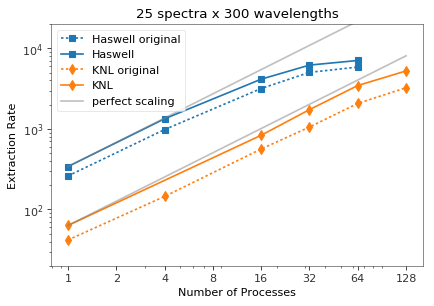

In [9]:
plot(h1['nproc'], h1['rate'], 's:', color='C0', label='Haswell original')
plot(h2['nproc'], h2['rate'], 's-', color='C0', label='Haswell')
plot(h2['nproc'], h2['nproc']*h2['rate'][0], color='0.5', alpha=0.5, label='_none_')

plot(k1['nproc'], k1['rate'], 'd:', color='C1', label='KNL original')
plot(k2['nproc'], k2['rate'], 'd-', color='C1', label='KNL')
plot(k2['nproc'], k2['nproc']*k2['rate'][0], color='0.5', alpha=0.5, label='perfect scaling')
semilogx()
semilogy()
xticks([1,2,4,8,16,32,64,128], [1,2,4,8,16,32,64,128])
legend(loc='upper left')
ylim(20, 20000)
xlabel('Number of Processes')
ylabel('Extraction Rate')
title('25 spectra x 300 wavelengths')
savefig('desi-extract-improvements.pdf')

## Build in plots for storytelling

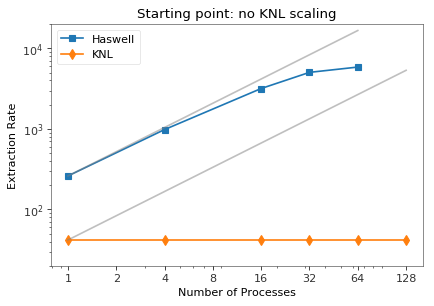

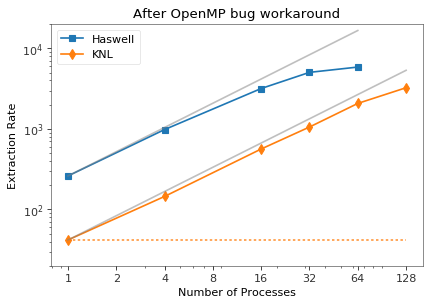

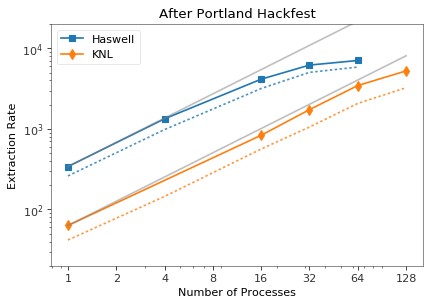

In [6]:
def labelit(title_=''):
    semilogx()
    semilogy()
    xticks([1,2,4,8,16,32,64,128], [1,2,4,8,16,32,64,128])
    legend(loc='upper left')
    title(title_)
    ylim(20, 20000)
    xlabel('Number of Processes')
    ylabel('Extraction Rate')

figure()
plot(h1['nproc'], h1['rate'], 's-', color='C0', label='Haswell')
plot(h1['nproc'], h1['nproc']*h1['rate'][0], color='0.5', alpha=0.5, label='_none_')
plot(k1['nproc'], k1['rate'][0]*np.ones(len(k1['nproc'])), 'd-', color='C1', label='KNL')
plot(k1['nproc'], k1['nproc']*k1['rate'][0], color='0.5', alpha=0.5, label='_none_')
labelit('Starting point: no KNL scaling')
savefig('portland1.pdf')

figure()
plot(h1['nproc'], h1['rate'], 's-', color='C0', label='Haswell')
plot(h1['nproc'], h1['nproc']*h1['rate'][0], color='0.5', alpha=0.5, label='_none_')
plot(k1['nproc'], k1['rate'], 'd-', color='C1', label='KNL')
plot(k1['nproc'], k1['rate'][0]*np.ones(len(k1['nproc'])), ':', color='C1', label='_none_', alpha=0.8)
plot(k1['nproc'], k1['nproc']*k1['rate'][0], color='0.5', alpha=0.5, label='_none_')
labelit('After OpenMP bug workaround')
savefig('portland2.pdf')

figure()
plot(h1['nproc'], h1['rate'], ':', color='C0', label='_none_', alpha=0.8)
plot(h2['nproc'], h2['rate'], 's-', color='C0', label='Haswell')
plot(h2['nproc'], h2['nproc']*h2['rate'][0], color='0.5', alpha=0.5, label='_none_')

plot(k1['nproc'], k1['rate'], ':', color='C1', label='_none_', alpha=0.8)
plot(k2['nproc'], k2['rate'], 'd-', color='C1', label='KNL')
plot(k2['nproc'], k2['nproc']*k2['rate'][0], color='0.5', alpha=0.5, label='_none_')
labelit('After Portland Hackfest')
savefig('portland3.pdf')


In [7]:
print('For 25 spectra x 300 wavelengths...')
print('Starting point ratios of HSW/KNL')
print('    per processes {:.2f}'.format(h1['rate'][0]/k1['rate'][0]))
print('    per node      {:.2f}'.format(np.max(h1['rate'])/np.max(k1['rate'])))

print('Ending ratios of HSW/KNL')
print('    per processes {:.2f}'.format(h2['rate'][0]/k2['rate'][0]))
print('    per node      {:.2f}'.format(np.max(h2['rate'])/np.max(k2['rate'])))

print('Haswell per-node improvement {:.2f}'.format(np.max(h2['rate'])/np.max(h1['rate'])))
print('KNL per-node improvement     {:.2f}'.format(np.max(k2['rate'])/np.max(k1['rate'])))

print('Original HSW / Current KNL {:.2f}'.format(np.max(h1['rate'])/np.max(k2['rate'])))
print('Original HSW rate {:.1f}'.format(np.max(h1['rate'])))

For 25 spectra x 300 wavelengths...
Starting point ratios of HSW/KNL
    per processes 6.24
    per node      1.80
Ending ratios of HSW/KNL
    per processes 5.39
    per node      1.35
Haswell per-node improvement 1.21
KNL per-node improvement     1.62
Original HSW / Current KNL 1.12
Original HSW rate 5868.3
